In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV


In [2]:
DIR_ = "D:/Drive/OneDrive/Documents/MIMIC"
DIR = "D:/Workspace/MIMIC_DATA/mimic-iii-clinical-database-1.4/"

In [3]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

# Natural Language

In [4]:
import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [5]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [6]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

In [7]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex']

In [8]:
porter = PorterStemmer()

In [9]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

# Model
## Words, Train and Test

In [10]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

Repartition data

In [11]:
df_train, df_test = train_test_split(adm_notes, test_size=0.2)

Subsample non-readmitted patients to match size of readmitted ones

In [12]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

In [13]:
rows_pos = df_test['READM_WITHIN_30'] == 1
df_test_pos = df_test.loc[rows_pos]
df_test_neg = df_test.loc[~rows_pos]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n = len(df_test_pos))], axis = 0)
df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)

In [14]:
print(df_train.shape)
print(df_test.shape)

(4812, 10)
(1114, 10)


Sparse Matrix with word count

In [15]:
# Tokenize and stem function
def tokenize_stem(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Assuming df_train and df_test are already defined and contain the required columns

# Vectorization
vect = CountVectorizer(lowercase=True, max_features=1000, tokenizer=tokenize_stem, token_pattern=None)

# Fit the vectorizer
vect.fit(df_train['TEXT'].values)

# Transform the text data
X_train_tf = vect.transform(df_train['TEXT'].values)
X_test_tf = vect.transform(df_test['TEXT'].values)


# Extract target variables
y_train = df_train['READM_WITHIN_30']
y_test = df_test['READM_WITHIN_30']


In [16]:
metrics = ['roc_auc', 'accuracy', 'precision', 'recall']

## Support Vector Machine

In [17]:
grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 2]
}

model_svm = GridSearchCV(SVC(), param_grid=grid)
model_svm.fit(X_test_tf, y_test)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 2], 'kernel': ['linear', 'poly', 'rbf']})

In [18]:
model_svm.best_params_

{'C': 2, 'kernel': 'rbf'}

In [19]:
model_svm = SVC(C=1, kernel='rbf')
scores_svm = cross_validate(model_svm, X_train_tf, y_train, cv=5, scoring=metrics, return_train_score=True)

In [20]:
print('Set\t\t', 'Train\t\t', '\t Sd Train')
print('AUC\t\t', np.mean(scores_svm['train_roc_auc']), '\t', np.std(scores_svm['train_roc_auc']))
print('Accuracy\t', np.mean(scores_svm['train_accuracy']), '\t', np.std(scores_svm['train_accuracy']))
print('Precission\t', np.mean(scores_svm['train_precision']), '\t', np.std(scores_svm['train_precision']))
print('Recall\t\t', np.mean(scores_svm['train_recall']), '\t', np.std(scores_svm['train_recall']))

Set		 Train		 	 Sd Train
AUC		 0.7740864123310878 	 0.0025231317110981475
Accuracy	 0.6984623160679279 	 0.0019387663864241134
Precission	 0.7411202626804692 	 0.0031680394832970618
Recall		 0.6100374220374221 	 0.004109178174346998


In [21]:
print('Set\t\t', 'Test\t\t', '\t Sd Test')
print('AUC\t\t', np.mean(scores_svm['test_roc_auc']), '\t', np.std(scores_svm['test_roc_auc']))
print('Accuracy\t', np.mean(scores_svm['test_accuracy']), '\t', np.std(scores_svm['test_accuracy']))
print('Precission\t', np.mean(scores_svm['test_precision']), '\t', np.std(scores_svm['test_precision']))
print('Recall\t\t', np.mean(scores_svm['test_recall']), '\t', np.std(scores_svm['test_recall']))

Set		 Test		 	 Sd Test
AUC		 0.6677065933550954 	 0.009293929768656112
Accuracy	 0.6217811629026582 	 0.005416075762879975
Precission	 0.6450445570836413 	 0.00866824826785391
Recall		 0.5419768635536271 	 0.0030324012864771997


## Multi-layer Perceptron

In [22]:
# Define the parameter grid
param_dist = {
    'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.01, 0.001, 0.0001]
}

# Initialize the RandomizedSearchCV with the MLPClassifier
model_mlp = RandomizedSearchCV(MLPClassifier(hidden_layer_sizes=(10, 2), max_iter=1000), param_distributions=param_dist, cv=5, n_iter=10, n_jobs=-1, verbose=2)

# Fit the model to the training data
model_mlp.fit(X_train_tf, y_train)

# Access the best parameters found by the randomized search
best_params = model_mlp.best_params_
print("Best parameters found by randomized search:", best_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found by randomized search: {'solver': 'adam', 'learning_rate_init': 0.0001, 'alpha': 0.01}


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [23]:

# Option 1: Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tf, y_train)

# Initialize the MLPClassifier with adjusted parameters
model_mlp_best = MLPClassifier(hidden_layer_sizes=(10, 2), 
                               alpha=best_params['alpha'], 
                               learning_rate_init=best_params['learning_rate_init'], 
                               solver=best_params['solver'], 
                               max_iter=6000,
                               early_stopping=True,  # Enable early stopping
                               validation_fraction=0.1)  # Use 10% of data for validation

# Define the metrics for cross-validation with zero_division handling
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=1),
    'recall': make_scorer(recall_score, zero_division=1),
    'f1': make_scorer(f1_score, zero_division=1),
    'roc_auc': 'roc_auc'
}

# Perform cross-validation on the resampled data
scores_mlp = cross_validate(model_mlp_best, X_resampled, y_resampled, cv=5, scoring=scoring, return_train_score=True)

# Output results
print("Cross-validation results:", scores_mlp)


Cross-validation results: {'fit_time': array([1.80698848, 0.46373463, 0.6175375 , 0.48603916, 0.48197675]), 'score_time': array([0.01562309, 0.01562381, 0.01562572, 0.02428484, 0.01844049]), 'test_accuracy': array([0.58359294, 0.50051921, 0.48648649, 0.5031185 , 0.50831601]), 'train_accuracy': array([0.66147051, 0.4998701 , 0.51688312, 0.51974026, 0.50233766]), 'test_precision': array([0.62461538, 1.        , 0.49245064, 0.50190597, 0.50666667]), 'train_precision': array([0.72881356, 1.        , 0.50938493, 0.51175743, 0.5018649 ]), 'test_recall': array([0.42116183, 0.        , 0.88149688, 0.82120582, 0.63201663]), 'train_recall': array([0.51403326, 0.        , 0.91636364, 0.85922078, 0.62909091]), 'test_f1': array([0.50309789, 0.        , 0.6318927 , 0.62302839, 0.56244218]), 'train_f1': array([0.60286498, 0.        , 0.65478842, 0.64145821, 0.55832181]), 'test_roc_auc': array([0.60832809, 0.49039432, 0.50211142, 0.49333077, 0.49909449]), 'train_roc_auc': array([0.68160191, 0.51203931

In [24]:
# Print cross-validation results
print('Set\t\t', 'Train\t\t', 'Sd Train')
print('AUC\t\t', np.mean(scores_mlp['train_roc_auc']), '\t', np.std(scores_mlp['train_roc_auc']))
print('Accuracy\t', np.mean(scores_mlp['train_accuracy']), '\t', np.std(scores_mlp['train_accuracy']))
print('Precision\t', np.mean(scores_mlp['train_precision']), '\t', np.std(scores_mlp['train_precision']))
print('Recall\t\t', np.mean(scores_mlp['train_recall']), '\t', np.std(scores_mlp['train_recall']))
print('F1 Score\t', np.mean(scores_mlp['train_f1']), '\t', np.std(scores_mlp['train_f1']))


Set		 Train		 Sd Train
AUC		 0.5462031511205537 	 0.06798540615479089
Accuracy	 0.5400603293822311 	 0.06120257391201039
Precision	 0.6503641619791343 	 0.1946990141939245
Recall		 0.5837417177417178 	 0.32686274329375975
F1 Score	 0.49148668366410214 	 0.24802827860013943


In [25]:
print('Set\t\t', 'Test\t\t', '\t Sd Test')
print('AUC\t\t', np.mean(scores_mlp['test_roc_auc']), '\t', np.std(scores_mlp['test_roc_auc']))
print('Accuracy\t', np.mean(scores_mlp['test_accuracy']), '\t', np.std(scores_mlp['test_accuracy']))
print('Precission\t', np.mean(scores_mlp['test_precision']), '\t', np.std(scores_mlp['test_precision']))
print('Recall\t\t', np.mean(scores_mlp['test_recall']), '\t', np.std(scores_mlp['test_recall']))
print('F1 Score\t', np.mean(scores_mlp['test_f1']), '\t', np.std(scores_mlp['test_f1']))

Set		 Test		 	 Sd Test
AUC		 0.5186518164451412 	 0.04502787713092768
Accuracy	 0.5164066294907416 	 0.03436177420667939
Precission	 0.6251277324239795 	 0.19357133930597073
Recall		 0.5511762320890952 	 0.319143185847988
F1 Score	 0.4640922330459727 	 0.23664042478918004


## Random Forest

In [26]:
grid = {
    'max_depth': [10, 20, 30, 40],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
    'n_estimators': [100, 200, 300]
}
model_rf = GridSearchCV(RandomForestClassifier(bootstrap=False), param_grid=grid)
model_rf.fit(X_test_tf, y_test)

GridSearchCV(estimator=RandomForestClassifier(bootstrap=False),
             param_grid={'max_depth': [10, 20, 30, 40],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]})

In [27]:
model_rf.best_params_

{'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [28]:
model_rf = RandomForestClassifier(
    bootstrap=False, max_depth=20, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=100
)
scores_rf = cross_validate(model_rf, X_train_tf, y_train, cv=5, scoring=metrics, return_train_score=True)

In [29]:
print('Set\t\t', 'Train\t\t', '\t Sd Train')
print('AUC\t\t', np.mean(scores_rf['train_roc_auc']), '\t', np.std(scores_rf['train_roc_auc']))
print('Accuracy\t', np.mean(scores_rf['train_accuracy']), '\t', np.std(scores_rf['train_accuracy']))
print('Precission\t', np.mean(scores_rf['train_precision']), '\t', np.std(scores_rf['train_precision']))
print('Recall\t\t', np.mean(scores_rf['train_precision']), '\t', np.std(scores_rf['train_precision']))

Set		 Train		 	 Sd Train
AUC		 0.9993126339438027 	 0.00012505394134589012
Accuracy	 0.9891417504293575 	 0.0008596594841735451
Precission	 0.9986227108629109 	 0.0002609919608423704
Recall		 0.9986227108629109 	 0.0002609919608423704


In [30]:
print('Set\t\t', 'Test\t\t', '\t Sd Test')
print('AUC\t\t', np.mean(scores_rf['test_roc_auc']), '\t', np.std(scores_rf['test_roc_auc']))
print('Accuracy\t', np.mean(scores_rf['test_accuracy']), '\t', np.std(scores_rf['test_accuracy']))
print('Precission\t', np.mean(scores_rf['test_precision']), '\t', np.std(scores_rf['test_precision']))
print('Recall\t\t', np.mean(scores_rf['test_recall']), '\t', np.std(scores_rf['test_recall']))

Set		 Test		 	 Sd Test
AUC		 0.6819069589671984 	 0.010722062650976794
Accuracy	 0.6292608208496059 	 0.010315798972472486
Precission	 0.6270156468874004 	 0.009773754255914424
Recall		 0.6379870774061646 	 0.012875200298392033


## Naive Bayes

In [31]:
# Define the parameter grid
param_grid = {'alpha': [10, 1, 0.1, 0.01, 0.001]}

# Initialize the GridSearchCV with the MultinomialNB
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the model to the training data
grid_search_nb.fit(X_train_tf, y_train)

# Get the best parameters
best_alpha = grid_search_nb.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

Best alpha: 10


In [32]:

# Initialize the MultinomialNB with the best alpha parameter
model_nb = MultinomialNB(alpha=best_alpha)

# Define the metrics for cross-validation
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Perform cross-validation
scores_nb = cross_validate(model_nb, X_train_tf, y_train, cv=5, scoring=metrics, return_train_score=True)

In [33]:
# Print cross-validation results
print('Set\t\t', 'Train\t\t', 'Sd Train')
print('AUC\t\t', np.mean(scores_nb['train_roc_auc']), '\t', np.std(scores_nb['train_roc_auc']))
print('Accuracy\t', np.mean(scores_nb['train_accuracy']), '\t', np.std(scores_nb['train_accuracy']))
print('Precision\t', np.mean(scores_nb['train_precision']), '\t', np.std(scores_nb['train_precision']))
print('Recall\t\t', np.mean(scores_nb['train_recall']), '\t', np.std(scores_nb['train_recall']))
print('F1 Score\t', np.mean(scores_nb['train_f1']), '\t', np.std(scores_nb['train_f1']))

Set		 Train		 Sd Train
AUC		 0.6734183639877147 	 0.0026134150780360204
Accuracy	 0.6261949232892335 	 0.004369307292110166
Precision	 0.6445396796392868 	 0.008274878045143765
Recall		 0.5633829413829414 	 0.00874023419152409
F1 Score	 0.6011262665640174 	 0.002871598848647839


In [34]:
print('Set\t\t', 'Test\t\t', '\t Sd Test')
print('AUC\t\t', np.mean(scores_nb['test_roc_auc']), '\t', np.std(scores_nb['test_roc_auc']))
print('Accuracy\t', np.mean(scores_nb['test_accuracy']), '\t', np.std(scores_nb['test_accuracy']))
print('Precission\t', np.mean(scores_nb['test_precision']), '\t', np.std(scores_nb['test_precision']))
print('Recall\t\t', np.mean(scores_nb['test_recall']), '\t', np.std(scores_nb['test_recall']))

Set		 Test		 	 Sd Test
AUC		 0.6540547427444539 	 0.008658727420077068
Accuracy	 0.6151318104589132 	 0.007053694917402308
Precission	 0.6306097515565947 	 0.012165307860963905
Recall		 0.5573571656559209 	 0.01258679884817839


There is no improvement when using the whole Dataset with ComplementNB, same scores on test

## XGBoost

In [35]:
grid = {
    'min_child_weight': [1, 5],
    'gamma': [0.5, 1, 1.5],
    'max_depth': [3, 5],
    'eta': [0.1,0.01,0.001]
}

model_xgb = GridSearchCV(XGBClassifier(), param_grid=grid)
model_xgb.fit(X_test_tf, y_test)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...one,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_ch

In [36]:
model_xgb.best_params_

{'eta': 0.1, 'gamma': 1, 'max_depth': 5, 'min_child_weight': 1}

In [37]:
model_xgb = XGBClassifier(
    min_child_weight=1, gamma=1.5, max_depth=5, eta=0.01
)
scores_xgb = cross_validate(model_xgb, X_train_tf, y_train, cv=5, scoring=metrics, return_train_score=True)

In [38]:
print('Set\t\t', 'Train\t\t', '\t Sd Train')
print('AUC\t\t', np.mean(scores_xgb['train_roc_auc']), '\t', np.std(scores_xgb['train_roc_auc']))
print('Accuracy\t', np.mean(scores_xgb['train_accuracy']), '\t', np.std(scores_xgb['train_accuracy']))
print('Precission\t', np.mean(scores_xgb['train_precision']), '\t', np.std(scores_xgb['train_precision']))
print('Recall\t\t', np.mean(scores_xgb['train_precision']), '\t', np.std(scores_xgb['train_precision']))

Set		 Train		 	 Sd Train
AUC		 0.8587153292477968 	 0.006308650497813779
Accuracy	 0.774522483492086 	 0.007718288579186365
Precission	 0.7929099234579235 	 0.0074054330986203926
Recall		 0.7929099234579235 	 0.0074054330986203926


In [39]:
print('Set\t\t', 'Test\t\t', '\t Sd Test')
print('AUC\t\t', np.mean(scores_xgb['test_roc_auc']), '\t', np.std(scores_xgb['test_roc_auc']))
print('Accuracy\t', np.mean(scores_xgb['test_accuracy']), '\t', np.std(scores_xgb['test_accuracy']))
print('Precission\t', np.mean(scores_xgb['test_precision']), '\t', np.std(scores_xgb['test_precision']))
print('Recall\t\t', np.mean(scores_xgb['test_recall']), '\t', np.std(scores_xgb['test_recall']))

Set		 Test		 	 Sd Test
AUC		 0.6753096555595672 	 0.016566031822220134
Accuracy	 0.6336200326854532 	 0.01205788762650399
Precission	 0.6378737690125987 	 0.012257182307993142
Recall		 0.6184358312989018 	 0.02226036116193176


Confusion Matrix:
[[17  0]
 [ 0 13]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



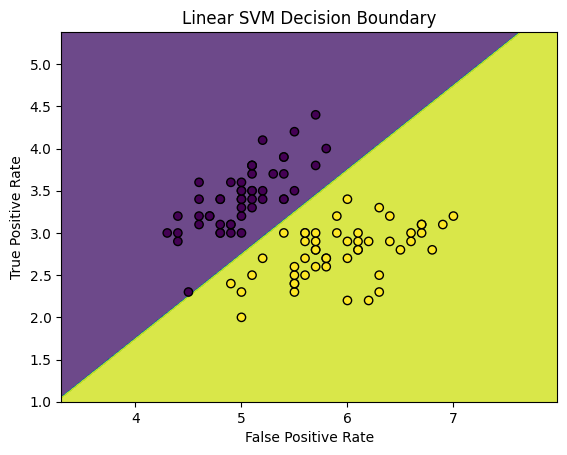

In [40]:
# SVM
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Load a simple dataset
iris = datasets.load_iris()
X = iris.data[:, :2]  # Using only two features for visualization
y = iris.target

# Binary classification (for simplicity)
X = X[y != 2]
y = y[y != 2]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a linear SVM classifier
linear_svm = SVC(kernel='linear', C=1.0)

# Train the model
linear_svm.fit(X_train, y_train)

# Predict on the test data
y_pred = linear_svm.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the decision boundary
import matplotlib.pyplot as plt
import numpy as np

# Create a grid to plot the decision boundary
h = .02  # Step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = linear_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Linear SVM Decision Boundary')
plt.show()
